## Análise de Sentimento e modelagem de tópicos com Python

### Construindo o Crawler

O jogo cyberpunk 2077 foi um projeto da desenvolvedora CD projekt red que por anos foi aguardado por muitos jogadores. O jogo foi lançado no final de 2020 para as três plataformas: PC, PS4 e Xbox. Infelizmente, o jogo foi lançado sem estar totalmente finalizado e otimizado para todas as plataformas. Os jogadores, principalmente do ps4, relataram muitos bugs grotescos no jogo que acabou fazendo com o que o jogo fosse chamado por alguns especialistas como o grande fracasso da geração. E que tal então analisar então as reviews do usuários em relação ao jogo?

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import nltk.corpus
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('mac_morpho')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from PIL import Image
import re
from langdetect import detect, DetectorFactory
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import smart_open
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from wordcloud import WordCloud, ImageColorGenerator
from pprint import pprint
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raphael.coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raphael.coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\raphael.coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raphael.coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\raphael.coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


Vamos comçear construindo o nosso crawler

Primeiro, precisamos de dados. Os nossos dados estão no site do metacritic, então precisamos construir um crawler que pegue as informações contidas no site:
No código abaixo vamos usar as libs request e beuatifulSoup. Elas vão ser responsáveis pela nossa comunicação com o site do metacritic. e cada conjunto de dados que vamos pegar, vamos guardar em um dicionário:

In [3]:
#################################################################--PC--#################################################################################
reviews = {'name':[], 'date':[], 'rating':[], 'review':[],'platform':[]}

extraction = {'https://www.metacritic.com/game/pc/cyberpunk-2077/user-reviews?page=':129, 
             'https://www.metacritic.com/game/playstation-4/cyberpunk-2077/user-reviews?page=':50,
             'https://www.metacritic.com/game/xbox-one/cyberpunk-2077/user-reviews?page=':16}

platform = ['PC','PS4','XBOX ONE']

i = 0

for row in extraction:

    for page in range(0,extraction[row]): 

        url = row + str(page)

        user_agent =  {'User-agent': 'Chrome/89.0.4389.90'}

        response = requests.get(url, headers = user_agent)

        soup = BeautifulSoup(response.text, 'html.parser')

        for review in soup.find_all('div', class_='review_content'):

            if review.find('div', class_='name') == None:
                            break

            reviews['name'].append(review.find('div', class_='name').find('a').text)
            reviews['date'].append(review.find('div', class_='date').text)
            reviews['rating'].append(review.find('div', class_='review_grade').find_all('div')[0].text)

            if review.find('span', class_='blurb blurb_expanded'):
                reviews['review'].append(review.find('span', class_='blurb blurb_expanded').text)
            else:
                reviews['review'].append(review.find('div', class_='review_body').find('span'))
                
            reviews['platform'].append(platform[i])
    i=i+1
    
reviews_cyberpunk = pd.DataFrame(reviews)

Aqui vamo guardar o nosso dataframe em um csv para não precisamos reexecutar o crawler caso tivessemos que começar o processo novamente.

In [27]:
reviews_cyberpunk.to_csv('cyberpunk.csv', index=False)

In [6]:
reviews_cyberpunk = pd.read_csv('cyberpunk.csv')

In [7]:
reviews_cyberpunk.head()

,name,date,rating,review,platform
0,Brave_New_World,"Feb 12, 2021",0,This game is just awful. Extremely overmarkete...,PC
1,Agrajag,"Jan 21, 2021",4,"Feel betrayed, and not because I was on the hy...",PC
2,TheTownDrunk,"Feb 4, 2021",1,This release is an AUDACITY! What we got here ...,PC
3,Kodesh,"Dec 12, 2020",1,I'm not the kind of person who writes review b...,PC
4,DecadeReviews,"Jan 23, 2021",2,<span>Graphics - 9/10 (with ray tracing) / 7.7...,PC


### Analise exploratória

Agora que já temos o nosso dataframe, podemos manipular ele um pouquinho pra descobrir algumas informações legais. Primeiro, vamos criar uma coluna de critic. Essa coluna vai ser baseada nas notas dos usuários e ela que vai nos dizer se a review foi positiva ou negativa ou foi "Mixed"

Então temos que se a nota foi menor que 4 então a review foi negativa, entre 4 e 7 mixed e maior que 7 positiva. Essas faixas são definidas pelo próprio metacritic. Agora vamos descobrir a distribuição das criticas por plataforma.

In [8]:
reviews_cyberpunk['rating'] = reviews_cyberpunk['rating'].astype(int)

reviews_cyberpunk['critic'] = ['Negative' if row.rating < 4 else
                               'Mixed' if row.rating >=4 and row.rating <= 6 else
                               'Positive' if row.rating >= 7 else 'error' for i, row in reviews_cyberpunk.iterrows()]

Plotamos então, com o matplotlib e o seaborn a nossa primeira visualização! Aqui vemos que apersar do número de reviews positivas pra PC ser bem alto, o número total de reviews negativas é considerável. Vamos decorbri agora a média das notas:

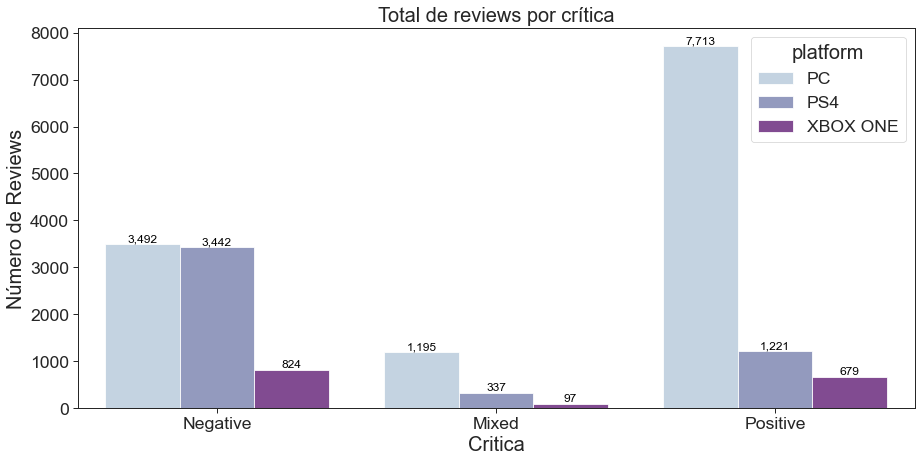

In [9]:
plt.figure(figsize=(15,7))
sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
sns.set_style('ticks')
sns.countplot(x='critic',
              hue='platform',
              palette = "BuPu",
              data=reviews_cyberpunk)
ax = plt.gca()
for p in ax.patches:
    labels = ax.text(p.get_x() + p.get_width()/2, np.nan_to_num(p.get_height(),0), "{:0,.0f}".format(np.nan_to_num(p.get_height(),0)) ,
            fontsize=12, color='black', ha='center', va='bottom')
plt.xlabel("Critica")
plt.ylabel('Número de Reviews')
plt.title("Total de reviews por crítica")
plt.show()

In [10]:
rating_mean = reviews_cyberpunk.groupby(['platform'])['rating'].mean().to_frame().reset_index()

rating_mean.head()

,platform,rating
0,PC,6.551048
1,PS4,2.965400
2,XBOX ONE,4.556250


Na ultimo plot, vimos um grande volume de reviews positivas para PC. Aqui vemos que essa mesma plataforma é a que tem a média de notas mais alta. Enquanto que para PS4, onde houve grande parte de reclamação do público, a média ficou em menos de 3. Vamos ver agora como é a distribuição das reviews ao longo do tempo:

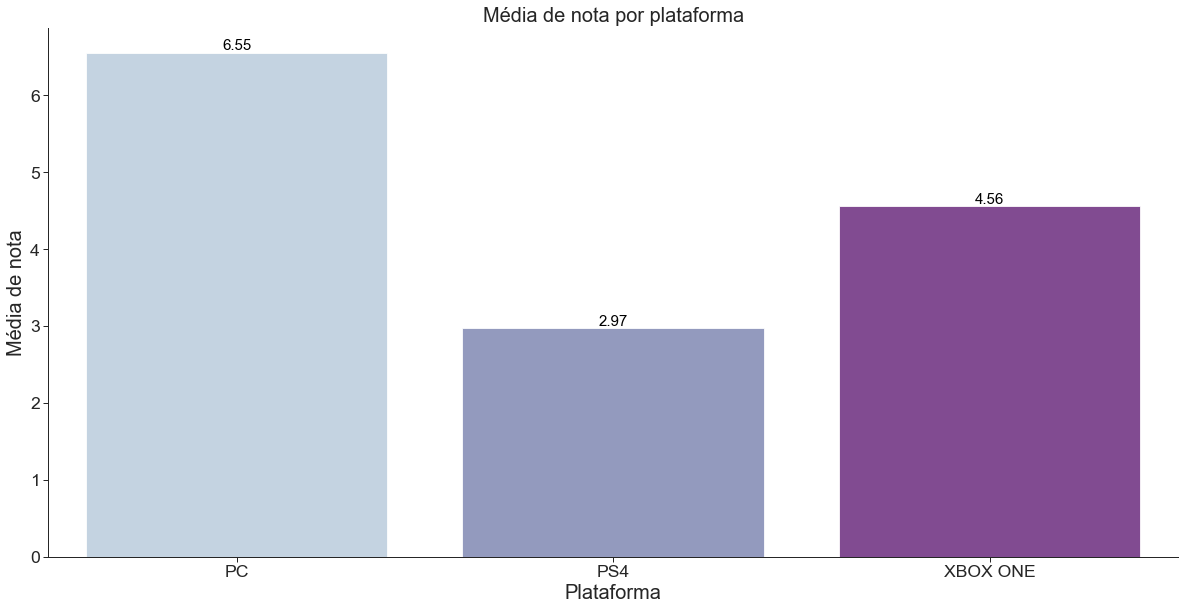

In [11]:
sns.set_style('ticks')
sns.catplot(x='platform',
              y='rating',
              palette = "BuPu",
              data=rating_mean,
              height=8.27, 
              aspect=20/10,
              kind='bar')
ax = plt.gca()
for p in ax.patches:
    labels = ax.text(p.get_x() + p.get_width()/2, np.nan_to_num(p.get_height(),0), "{:0,.2f}".format(np.nan_to_num(p.get_height(),0)) ,
            fontsize=15, color='black', ha='center', va='bottom')
plt.xlabel("Plataforma")
plt.ylabel('Média de nota')
plt.title("Média de nota por plataforma")
plt.show()

In [12]:
reviews_cyberpunk['date'] = pd.to_datetime(reviews_cyberpunk['date'])
reviews_cyberpunk['year'] = reviews_cyberpunk['date'].dt.year
reviews_cyberpunk['month'] = reviews_cyberpunk['date'].dt.month
reviews_cyberpunk['period'] = reviews_cyberpunk['year'].astype(str) + '-' + reviews_cyberpunk['month'].astype(str)

In [13]:
reviews_cyberpunk.head()

,name,date,rating,review,platform,critic,year,month,period
0,Brave_New_World,2021-02-12,0,This game is just awful. Extremely overmarkete...,PC,Negative,2021,2,2021-2
1,Agrajag,2021-01-21,4,"Feel betrayed, and not because I was on the hy...",PC,Mixed,2021,1,2021-1
2,TheTownDrunk,2021-02-04,1,This release is an AUDACITY! What we got here ...,PC,Negative,2021,2,2021-2
3,Kodesh,2020-12-12,1,I'm not the kind of person who writes review b...,PC,Negative,2020,12,2020-12
4,DecadeReviews,2021-01-23,2,<span>Graphics - 9/10 (with ray tracing) / 7.7...,PC,Negative,2021,1,2021-1


In [14]:
time_series = reviews_cyberpunk.groupby(['period','critic'])['rating'].count().to_frame().reset_index()

time_series.head()

,period,critic,rating
0,2020-12,Mixed,1429
1,2020-12,Negative,7279
2,2020-12,Positive,8729
3,2021-1,Mixed,149
4,2021-1,Negative,337


Aqui nós criamos uma nova coluna periodo.Como o jogo foi lançado no final de 2020, a maior parte das review saiu logo após do lançamento, por isso a concentração está entre 2020–12 e 2021–1. Vamos abrir esse período para olharmos melhor o dado:

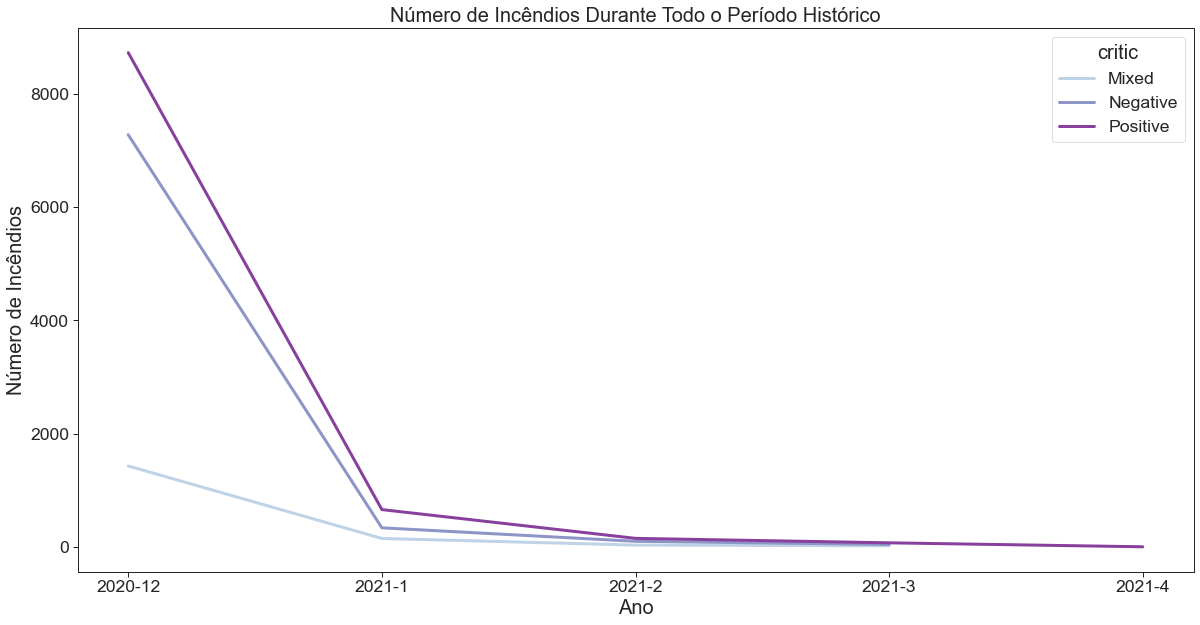

In [15]:
sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,
                                           "axes.labelsize":20, "legend.title_fontsize":20, "lines.linewidth": 3.0}) 
sns.set_style('ticks')
plt.figure(figsize=(20,10))
sns.lineplot(x='period', y='rating', 
            hue='critic', 
            palette = "BuPu",
            ci = None,
            data=time_series)
#plt.xticks(amazon_group_year['year'])
plt.xlabel('Ano')
plt.ylabel('Número de Incêndios')
plt.title('Número de Incêndios Durante Todo o Período Histórico')
#sns.despine()
plt.show()

In [16]:
reviews_2020 = reviews_cyberpunk.loc[reviews_cyberpunk['year'] == 2020]

time_series_2020 = reviews_2020.groupby(['date','critic'])['rating'].count().to_frame().reset_index()

time_series_2020.head()

,date,critic,rating
0,2020-12-11,Mixed,222
1,2020-12-11,Negative,1898
2,2020-12-11,Positive,1156
3,2020-12-12,Mixed,289
4,2020-12-12,Negative,1971


Mesmo em 2020, podemos ver que a grande concentração se dá nos primeiros dias da base histórica, tendo assim um mesmo padrão que o plot anterior.

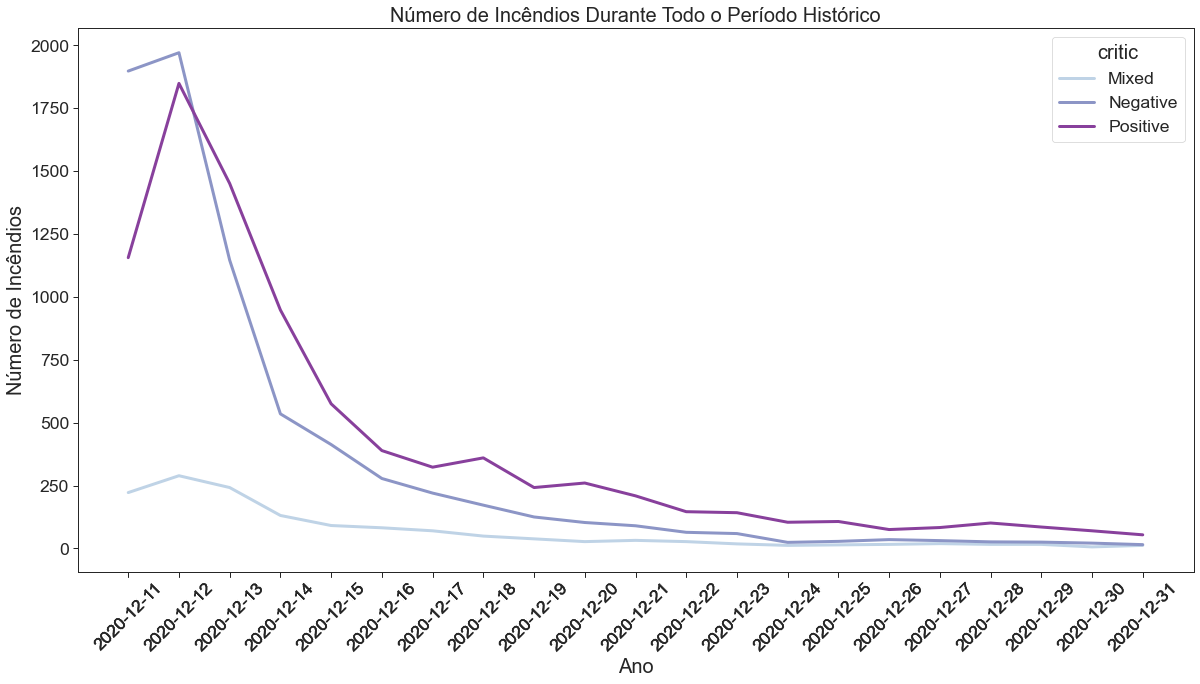

In [17]:
sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,
                                           "axes.labelsize":20, "legend.title_fontsize":20, "lines.linewidth": 3.0}) 
sns.set_style('ticks')
plt.figure(figsize=(20,10))
sns.lineplot(x='date', y='rating', 
            hue='critic', 
            palette = "BuPu",
            ci = None,
            data=time_series_2020)
plt.xticks(time_series_2020['date'])
plt.xticks(rotation=45)
plt.xlabel('Ano')
plt.ylabel('Número de Incêndios')
plt.title('Número de Incêndios Durante Todo o Período Histórico')
#sns.despine()
plt.show()

Agora vamos começar a brincar com o texto. Ainda na análise exploratória, há informações para descobrir. Vamos entender como a nossa base está divida entre os idiomas de escrita das reviews!
Para isso, vamos precisar fazer um pequeno tratamento antes. As reviews ainda vieram com algumas tags como span e br. Então, precisamos tirá-las.

In [18]:
trash_chars = ['<span>','</span>','<br>','\r']

for i in trash_chars:
    
    reviews_cyberpunk['review'] = reviews_cyberpunk['review'].str.replace(i, ' ')
    #reviews_cyberpunk['review'] = [str(r).replace(i,' ') for r in reviews]
    
#reviews = [str(r).replace("\'",'') for r in reviews]

In [19]:
reviews_cyberpunk.head()

,name,date,rating,review,platform,critic,year,month,period
0,Brave_New_World,2021-02-12,0,This game is just awful. Extremely overmarkete...,PC,Negative,2021,2,2021-2
1,Agrajag,2021-01-21,4,"Feel betrayed, and not because I was on the hy...",PC,Mixed,2021,1,2021-1
2,TheTownDrunk,2021-02-04,1,This release is an AUDACITY! What we got here ...,PC,Negative,2021,2,2021-2
3,Kodesh,2020-12-12,1,I'm not the kind of person who writes review b...,PC,Negative,2020,12,2020-12
4,DecadeReviews,2021-01-23,2,Graphics - 9/10 (with ray tracing) / 7.7/10 (...,PC,Negative,2021,1,2021-1


Agora com a base um pouco melhor, vamos descobrir o idioma das reviews! Para isso, vamos utilizar a lib langdetect, onde para cada linha do nosos dataframe na coluna de review, o texto vai ser analisado e determinado qual idioma foi escrito.

In [20]:
reviews = list(reviews_cyberpunk['review'])
language = []

for review in reviews:
    try:
        DetectorFactory.seed = 0
        language.append(detect(review))
    except:
        language.append('NA')

In [21]:
print(len(reviews))
print('-'*10)
print(len(language))
reviews_cyberpunk['language'] = language

reviews_cyberpunk.head(10)

19000
----------
19000


,name,date,rating,review,platform,critic,year,month,period,language
0,Brave_New_World,2021-02-12,0,This game is just awful. Extremely overmarkete...,PC,Negative,2021,2,2021-2,en
1,Agrajag,2021-01-21,4,"Feel betrayed, and not because I was on the hy...",PC,Mixed,2021,1,2021-1,en
2,TheTownDrunk,2021-02-04,1,This release is an AUDACITY! What we got here ...,PC,Negative,2021,2,2021-2,en
3,Kodesh,2020-12-12,1,I'm not the kind of person who writes review b...,PC,Negative,2020,12,2020-12,en
4,DecadeReviews,2021-01-23,2,Graphics - 9/10 (with ray tracing) / 7.7/10 (...,PC,Negative,2021,1,2021-1,en
5,Vizic,2020-12-12,2,"False Advertising, 90% of advertised features ...",PC,Negative,2020,12,2020-12,en
6,AxelLeRoux,2020-12-12,1,The worst deception I had in videogames. Even...,PC,Negative,2020,12,2020-12,en
7,XezonN,2020-12-12,0,What an absolute disaster. How could you ship ...,PC,Negative,2020,12,2020-12,en
8,difato,2020-12-12,1,The model of walking looks like I was walking ...,PC,Negative,2020,12,2020-12,en
9,alohamemeh,2020-12-12,2,"it only looks good, thats all. it can't be se...",PC,Negative,2020,12,2020-12,en


In [22]:
reviews_cyberpunk.language.unique()

array(['en', 'ru', 'es', 'pt', 'tr', 'cy', 'sl', 'pl', 'fr', 'de', 'NA',
       'id', 'lv', 'it', 'uk', 'ko', 'zh-cn', 'ro', 'ar', 'no', 'th',
       'cs', 'da', 'zh-tw', 'hr', 'ca', 'so', 'nl', 'sw', 'bg', 'hu',
       'af', 'sk', 'sv', 'fi', 'ja', 'mk', 'sq', 'tl', 'vi', 'et', 'fa'],
      dtype=object)

Vamos contar agora quantas review há de cada idioma na nossa base.

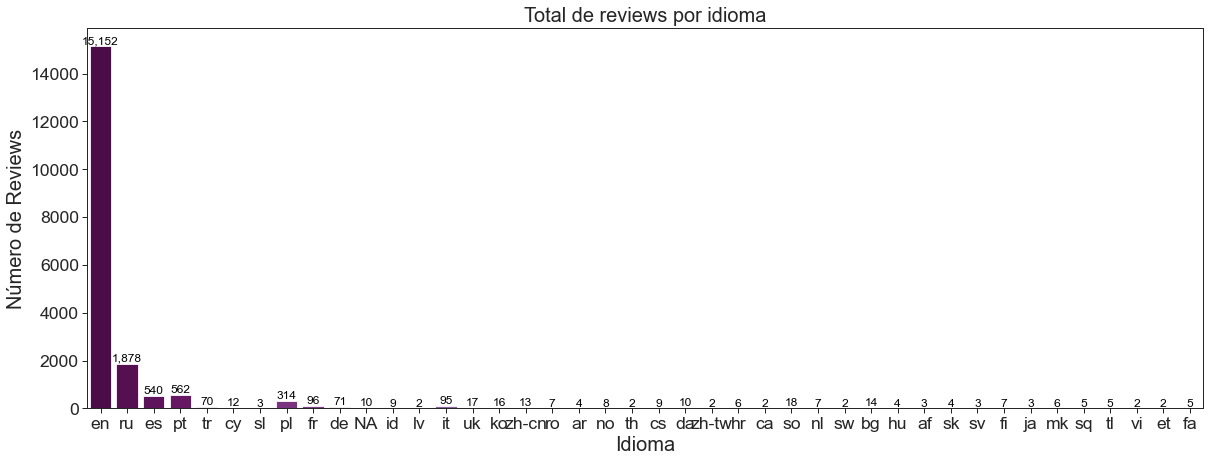

In [23]:
plt.figure(figsize=(20,7))
sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
sns.set_style('ticks')
sns.countplot(x='language',
              palette = "BuPu_r",
              data=reviews_cyberpunk)
ax = plt.gca()
for p in ax.patches:
    labels = ax.text(p.get_x() + p.get_width()/2, np.nan_to_num(p.get_height(),0), "{:0,.0f}".format(np.nan_to_num(p.get_height(),0)) ,
            fontsize=12, color='black', ha='center', va='bottom')
plt.xlabel("Idioma")
plt.ylabel('Número de Reviews')
plt.title("Total de reviews por idioma")
plt.show()

Vamos contar agora quantas reviews há para cada idioma dentre os 5 idiomas mais frequentes:

In [24]:
reviews_cyberpunk_top10_language = reviews_cyberpunk.groupby(['language'])['review'].count().to_frame().reset_index()

reviews_cyberpunk_top10_language = reviews_cyberpunk_top10_language.nlargest(5, 'review')

reviews_cyberpunk_top10_language.head()

,language,review
9,en,15152
28,ru,1878
26,pt,562
10,es,540
25,pl,314


A grande maioria das reviews foi escrita em inglês. A segunda maior russo, seguida por português, espanhol e polonês

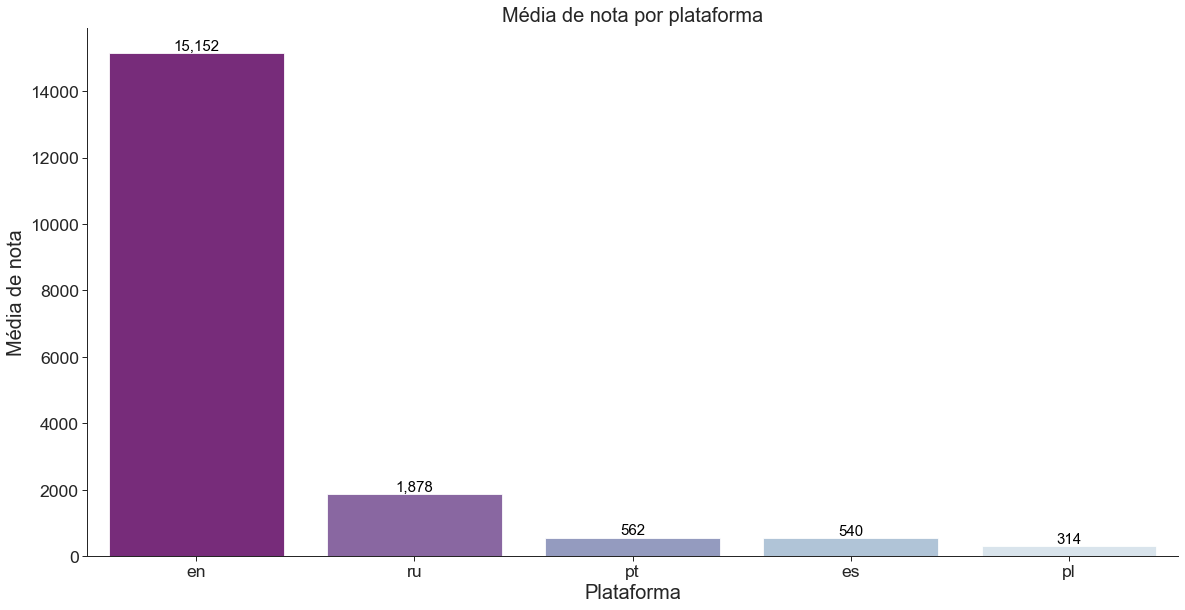

In [25]:
sns.set_style('ticks')
sns.catplot(x='language',
              y='review',
              palette = "BuPu_r",
              data=reviews_cyberpunk_top10_language,
              height=8.27, 
              aspect=20/10,
              kind='bar')
ax = plt.gca()
for p in ax.patches:
    labels = ax.text(p.get_x() + p.get_width()/2, np.nan_to_num(p.get_height(),0), "{:0,.0f}".format(np.nan_to_num(p.get_height(),0)) ,
            fontsize=15, color='black', ha='center', va='bottom')
plt.xlabel("Plataforma")
plt.ylabel('Média de nota')
plt.title("Média de nota por plataforma")
plt.show()

Tirando o russo e o polonês, conseguimos identificar bem palavras nas outras principais linguas, então iremos trabalhar com elas. Já que as demais não vamos usar, vamos cortar o nosso dataframe.

In [26]:
reviews_cyberpunk_top10_language_by_platform = reviews_cyberpunk.loc[reviews_cyberpunk['language'].isin(['en','ru','pt','es','pl'])]

reviews_cyberpunk_top10_language_by_platform.head()


,name,date,rating,review,platform,critic,year,month,period,language
0,Brave_New_World,2021-02-12,0,This game is just awful. Extremely overmarkete...,PC,Negative,2021,2,2021-2,en
1,Agrajag,2021-01-21,4,"Feel betrayed, and not because I was on the hy...",PC,Mixed,2021,1,2021-1,en
2,TheTownDrunk,2021-02-04,1,This release is an AUDACITY! What we got here ...,PC,Negative,2021,2,2021-2,en
3,Kodesh,2020-12-12,1,I'm not the kind of person who writes review b...,PC,Negative,2020,12,2020-12,en
4,DecadeReviews,2021-01-23,2,Graphics - 9/10 (with ray tracing) / 7.7/10 (...,PC,Negative,2021,1,2021-1,en


Por fim, na nossa análise exploratória, vamos ver a distribuição de reviews de cada idioma por plataforma

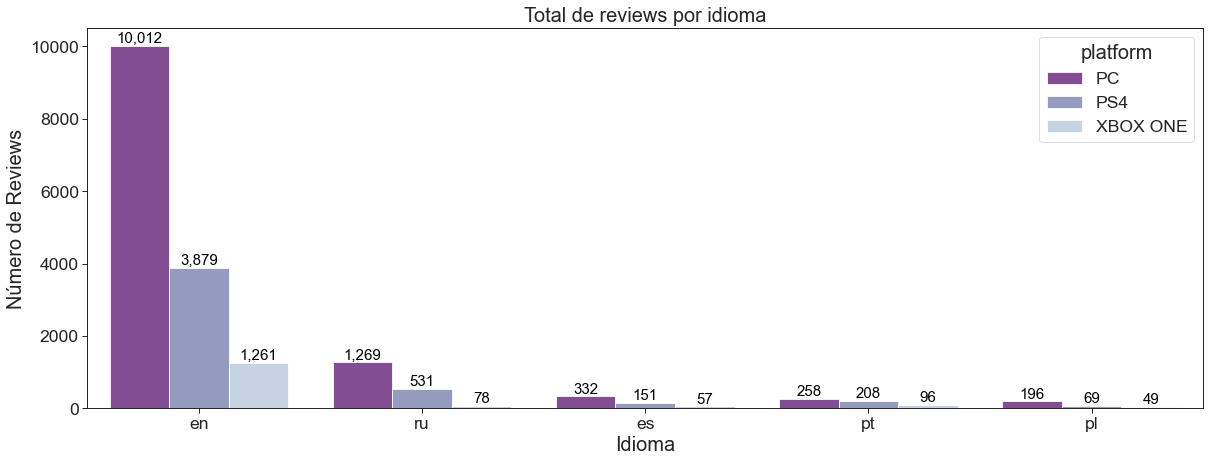

In [27]:
plt.figure(figsize=(20,7))
sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
sns.set_style('ticks')
sns.countplot(x='language',
              hue='platform',
              palette = "BuPu_r",
              data=reviews_cyberpunk_top10_language_by_platform)
ax = plt.gca()
for p in ax.patches:
    labels = ax.text(p.get_x() + p.get_width()/2, np.nan_to_num(p.get_height(),0), "{:0,.0f}".format(np.nan_to_num(p.get_height(),0)) ,
            fontsize=15, color='black', ha='center', va='bottom')
plt.xlabel("Idioma")
plt.ylabel('Número de Reviews')
plt.title("Total de reviews por idioma")
plt.show()

Vamos começar a preparar a nossa coluna de reviews. Primeiramente precisamos garantir que que essa coluna do tipo texto. Em seguida vamos tirar alguns caracteres especiais e deixar todo o texto com caixa baixa

In [28]:
reviews_cyberpunk['review'] = reviews_cyberpunk['review'].astype(str)

reviews_cyberpunk['review'] = reviews_cyberpunk['review'].map(lambda x: re.sub('[,\.!?]', '', x))

reviews_cyberpunk['review'] = reviews_cyberpunk['review'].map(lambda x: x.lower())

reviews_cyberpunk.head()

,name,date,rating,review,platform,critic,year,month,period,language
0,Brave_New_World,2021-02-12,0,this game is just awful extremely overmarketed...,PC,Negative,2021,2,2021-2,en
1,Agrajag,2021-01-21,4,feel betrayed and not because i was on the hyp...,PC,Mixed,2021,1,2021-1,en
2,TheTownDrunk,2021-02-04,1,this release is an audacity what we got here i...,PC,Negative,2021,2,2021-2,en
3,Kodesh,2020-12-12,1,i'm not the kind of person who writes review b...,PC,Negative,2020,12,2020-12,en
4,DecadeReviews,2021-01-23,2,graphics - 9/10 (with ray tracing) / 77/10 (w...,PC,Negative,2021,1,2021-1,en


Como temos três idiomas no nosso dataframe (inglês, português e espanhol) e dois tipos de review (positiva e negativa), vamos criar nuvens pra cada idioma pra cada tipo de review. Para isso, precisamos repartir mais uma vez o nosso conjunto de dados:

In [29]:
reviews_en_positive = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'en') & (reviews_cyberpunk['critic'] == 'Positive')]

reviews_en_negative = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'en') & (reviews_cyberpunk['critic'] == 'Negative')]


Agora vamos tratar o nosso texto, e vamos fazer isso em três etapas:

-Tokenizar o texto: o processo de tokenizar refere-se a pegar cada review e separar cada palavra. Um token é uma palavra.

-Retirar stopwords: Stopwords são palavras que não acrescentam sentido para uma frase, como artigos, por exemplo.

-Lemmatize: Palavras em terceira pessoa vão ser transformadas para primeira pessoa e verbos no passado e futuro são colocados no presente.

In [30]:
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer('english')

filtered_words_en_positive = []
list_en_positive = list(reviews_en_positive['review'])
tokens=[]

for row in list_en_positive:
    tokens = word_tokenize(row)
    for token in tokens:
        if token not in stop_words and len(token) > 3:
            filtered_words_en_positive.append(WordNetLemmatizer().lemmatize(token, pos='v'))

print(filtered_words_en_positive[:50])

filtered_words_en_negative = []
list_en_negative = list(reviews_en_negative['review'])
tokens=[]

for row in list_en_negative:
    tokens=word_tokenize(row)
    for token in tokens:
        if token not in stop_words and len(token) > 3:
            filtered_words_en_negative.append(WordNetLemmatizer().lemmatize(token, pos='v'))

print(filtered_words_en_negative[:50])

['enjoy', 'game', 'release', 'like', 'understand', 'people', 'want', 'play', 'fast', 'worth', 'negativity', 'sony', 'fan', 'realize', 'live', 'world', 'corporations', 'game', 'open', 'eye', 'reality', 'try', 'crush', 'contain', 'truth', 'go', 'world', 'deep', 'philosophical', 'honest', 'game', 'incredible', 'detail', 'nothing', 'like', 'today', 'benchmark', 'game', 'bug', 'everywhere', 'even', 'game', 'look', 'like', 'joke', 'everyone', 'buy', 'fool', 'company', 'best']
['game', 'awful', 'extremely', 'overmarketed', 'game', 'promote', 'next', 'masterpiece', 'time', 'ubisoft', 'rockstar', 'game', 'show', 'make', 'actually', 'good', 'game', 'come', 'seem', 'great', 'ubisoft', 'work', 'open', 'world', 'star', 'war', 'game', 'rockstar', 'game', 'prove', 'dead', 'redemption', 'still', 'best', 'best', 'ubisoft', 'assassin', 'creed', 'valhalla', 'pretty', 'solid', 'well', 'wait', 'project', 'release', 'audacity', 'tech', 'demo', 'real', 'game']


In [170]:
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer('english')

print("stopwords", stop_words)
print("-"*100)
tokens=[]
word_tokens=[]
filtered_words_en_positive=[]
lemmatize_en_positive = []
stemming_en_positive = []

for review in reviews_en_positive: 
    
    word_tokens = word_tokens + word_tokenize(review) 

tokens = [word for word in word_tokens if word not in stop_words]

for token in tokens:

    if len(token) > 3:

        filtered_words_en_positive.append(stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')))
        
        lemmatize_en_positive.append(WordNetLemmatizer().lemmatize(token, pos='v'))
        
        stemming_en_positive.append(stemmer.stem(token))
        
print("texto em tokens com stopwords - positive", word_tokens[:50]) 
print("-"*100)
print("texto em tokens sem stopwords - positive", tokens[:50])
print("-"*100)
print("texto apenas com o stemming - positive", stemming_en_positive[:50])
print("-"*100)
print("texto apenas com o lemmatize - positive", lemmatize_en_positive[:50])
print("-"*100)
print("tokens após stemming and lemmatization - positive",filtered_words_en_positive[:50])

tokens=[]       
word_tokens=[]
filtered_words_en_negative=[]
lemmatize_en_negative = []
stemming_en_negative = []

for review in reviews_en_negative: 
    
    word_tokens = word_tokens + word_tokenize(review) 

tokens = [word for word in word_tokens if word not in stop_words]

for token in tokens:

    if len(token) > 3:

        filtered_words_en_negative.append(stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')))

        lemmatize_en_negative.append(WordNetLemmatizer().lemmatize(token, pos='v'))
        
        stemming_en_negative.append(stemmer.stem(token))

print("texto em tokens com stopwords - negative", word_tokens[:50]) 
print("-"*100)
print("texto em tokens sem stopwords - negative", tokens[:50])
print("-"*100)
print("texto apenas com o stemming - negative", stemming_en_negative[:50])
print("-"*100)
print("texto apenas com o lemmatize - negative", lemmatize_en_negative[:50])
print("-"*100)
print("tokens após stemming and lemmatization - negative",filtered_words_en_negative[:50])

stopwords {'s', 'ours', 'any', 'by', 'me', 'be', 'on', 'd', 'before', 'than', 'further', "you'll", 'o', 'him', 'hers', 'here', 'because', 'out', 'was', 'will', 'those', 'and', 'hadn', 'needn', "doesn't", 'a', "you'd", 'did', 'of', 'does', 've', 'this', 'yourselves', 'that', 'while', 'at', 'themselves', 'once', "should've", 'ourselves', "wouldn't", 'it', 'if', 'ma', 'aren', 'wasn', 'his', 'above', 'into', 'they', 'having', 'hasn', 'too', 'wouldn', 'up', 'where', 'more', 'but', 'against', "haven't", 'its', 'after', "shan't", 'now', 'yourself', 'during', 'below', "mightn't", 'were', 'do', 'few', 'or', 'to', 'down', 'my', "didn't", 'y', 'the', "it's", 'he', 'is', "you've", 'you', 'which', 'as', 'doing', 'myself', 'theirs', 'has', 'these', 'in', 'own', 'each', 'won', 'herself', "mustn't", 'both', 'we', 'didn', 'she', 'over', "don't", "isn't", 'been', 'from', "won't", 'so', 'them', 'ain', 'isn', 'your', 'don', 'very', 'between', 'an', 'through', 'nor', 'when', 'itself', 'all', 'are', 'should

Vamos agora construir nossa nuvem de palavras. O plot vai contar a frequência que cada palavra aparece. Quanto mais ela aparecer maior e mais destaque ela vai ter na nuvem.

Nós vamos construir nossa nuvem em cima de uma imagem! O plot vai pegar a área da imagem (por isso é importante uma imagem sem fundo) e as cores da mesma e usar então esses parâmetros para plotar as palavras.

In [31]:
def drawWordCloud(words, filename):
    text = ''
    for word in words:
        text = text + ' ' + word

    mask = np.array(Image.open(r"1332793-middle.png"))
    image_colors = ImageColorGenerator(mask)

    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud( background_color="white", max_words=1000, mask=mask).generate(text)
    
    fig, axes = plt.subplots(1,2 , figsize=(16,20))
    axes[0].imshow(mask, cmap=plt.cm.gray, interpolation="bilinear")
    axes[1].imshow(wordcloud.recolor(color_func=image_colors,random_state=3),
           interpolation="bilinear")
    for ax in axes:
        ax.set_axis_off()
    plt.savefig(filename+".png", format="png", dpi=200)
    plt.show()

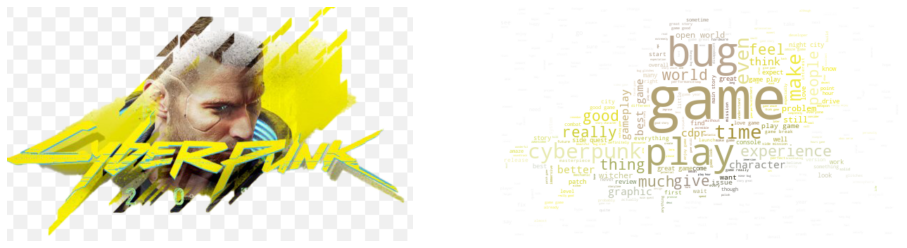

In [289]:
drawWordCloud(filtered_words_en_positive,"wordcloud_cyberpunk2077_en_positive")

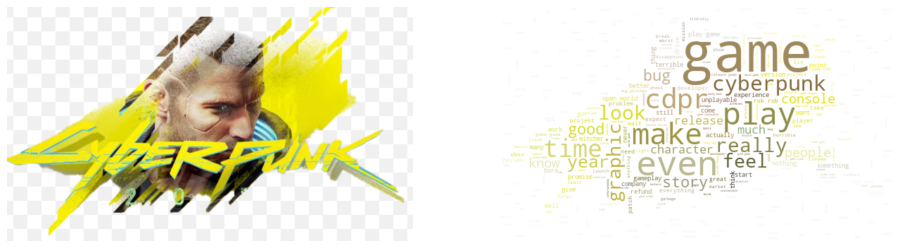

In [290]:
drawWordCloud(filtered_words_en_negative,"wordcloud_cyberpunk2077_en_negative")

Como vemos, temos muitas palavras que não tem um impacto legal para a nuvem (play, game, even, etc). Não conseguimos avaliar muito bem o sentimento dos usuários da forma como está a nuvem. Vamos adicionar mais um tratamento: identificar os adjetivos e plotar novamente apenas usando eles.

In [32]:
adjs_en_positive = [adjs_en_p for (adjs_en_p, pos) in nltk.pos_tag(filtered_words_en_positive) if(pos[:2] == 'JJ')]
adjs_en_negative = [adjs_en_n for (adjs_en_n, pos) in nltk.pos_tag(filtered_words_en_negative) if(pos[:2] == 'JJ')]
print(adjs_en_positive[:20])
print("-"*100)
print(adjs_en_negative[:20])

['understand', 'worth', 'live', 'open', 'philosophical', 'honest', 'incredible', 'fool', 'best', 'call', 'enough', 'witcher', 'come', 'open', 'alive', 'unhackable', "cp'77", 'worse', 'appreciate', 'ready']
----------------------------------------------------------------------------------------------------
['awful', 'overmarketed', 'masterpiece', 'ubisoft', 'good', 'great', 'ubisoft', 'open', 'dead', 'best', 'best', 'ubisoft', 'valhalla', 'solid', 'real', 'give', 'less', 'serious', 'promise', 'next-gen']


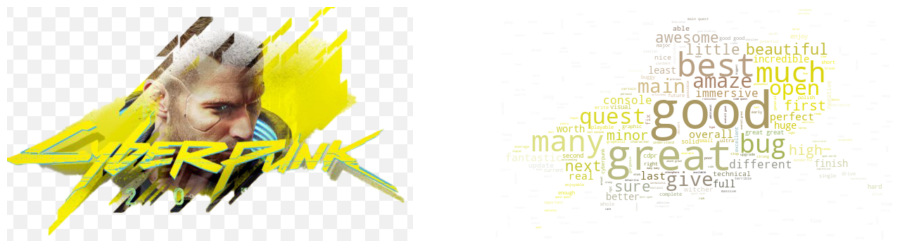

In [292]:
drawWordCloud(adjs_en_positive,"wordcloud_cyberpunk2077_en_positive")

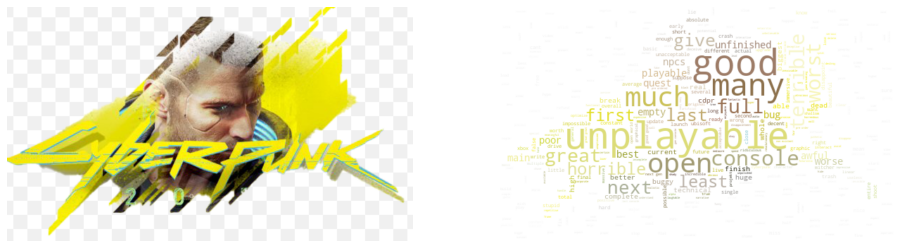

In [293]:
drawWordCloud(adjs_en_negative,"wordcloud_cyberpunk2077_en_positive")

Vamo fazer os mesmos tratamentos para o espanhol:

In [33]:
reviews_es_positive = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'es') & (reviews_cyberpunk['critic'] == 'Positive')]

reviews_es_negative = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'es') & (reviews_cyberpunk['critic'] == 'Negative')]


In [34]:
stop_words = set(stopwords.words('spanish')) 
stemmer = SnowballStemmer('spanish')

filtered_words_es_positive = []
list_es_positive = list(reviews_es_positive['review'])
tokens=[]

for row in list_es_positive:
    tokens = word_tokenize(row)
    for token in tokens:
        if token not in stop_words and len(token) > 3:
            filtered_words_es_positive.append(WordNetLemmatizer().lemmatize(token, pos='v'))

print(filtered_words_es_positive[:50])


filtered_words_es_negative = []
list_es_negative = list(reviews_es_negative['review'])
tokens=[]

for row in list_es_negative:
    tokens=word_tokenize(row)
    for token in tokens:
        if token not in stop_words and len(token) > 3:
            filtered_words_es_negative.append(WordNetLemmatizer().lemmatize(token, pos='v'))

print(filtered_words_es_negative[:50])

['bien', 'muchas', 'horas', 'jugadas', 'siendo', 'mayoria', 'historia', 'principal', 'anuncia', 'grande', 'bien', 'hecho', 'estaa', 'juego', 'entiendo', 'gente', 'juega', 'consola', 'verguenza', 'imperdonable', 'version', 'excepcion', 'bug', 'meramente', 'visuales', 'puedo', 'afirmar', 'cdprojekt', 'regalado', 'obra', 'maestra', 'niveles', 'consejo', 'empiece', 'jugar', 'historia', 'anima', 'rushearla', 'juego', 'puede', 'parecer', 'corto', 'ciudad', 'desaprovechada', 'niegas', 'placer', 'instinto', 'juegas', 'calma', 'metes']
['sacan', 'notas', 'revistas', 'especializadas', 'juego', 'roto', 'juego', 'lleno', 'bug', 'debieron', 'haberlo', 'retrasado', 'jugable', 'injugable', 'bug', 'texturas', 'hace', 'generaciones', 'decepción', 'absoluta', 'decepcion', 'juegoyo', 'pensando', 'maravillalos', 'npcs', 'ridiculos', 'enemigos', 'juego', 'graficamente', 'horrible', 'gunplay', 'debajo', 'juegos', 'doom', 'eternal', 'triste', 'acabado', 'juegono', 'entiendo', 'prensa', 'notas', 'estan', 'dan

In [35]:
adjs_es_positive = [adjs_es_p for (adjs_es_p, pos) in nltk.pos_tag(filtered_words_es_positive) if(pos[:2] == 'JJ')]
adjs_es_negative = [adjs_es_n for (adjs_es_n, pos) in nltk.pos_tag(filtered_words_es_negative) if(pos[:2] == 'JJ')]
print(adjs_es_positive[:20])
print("-"*100)
print(adjs_es_negative[:20])

['siendo', 'principal', 'imperdonable', 'afirmar', 'empiece', 'niegas', 'huecos', 'joya', 'mientras', 'actos', 'oficial', 'simplemente', 'arte', 'pasan', 'aguanta', 'medio-bajo', '25-35', 'increíble', 'nivel', 'ahora']
----------------------------------------------------------------------------------------------------
['sacan', 'especializadas', 'jugable', 'injugable', 'npcs', 'enemigos', 'horrible', 'eternal', 'notas', 'estan', 'ubisoft', 'injugable', 'mediante', 'hablar', 'nota', 'general', 'vías', 'explorable', 'iconos', 'igual']


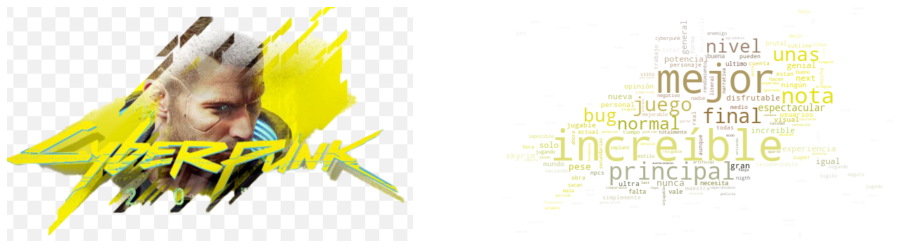

In [312]:
drawWordCloud(adjs_es_positive,"wordcloud_cyberpunk2077_es_positive")

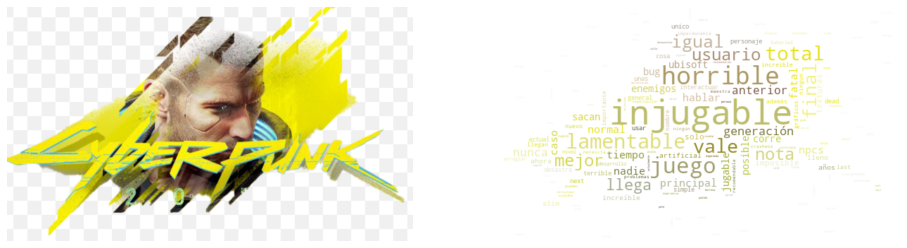

In [313]:
drawWordCloud(adjs_es_negative,"wordcloud_cyberpunk2077_es_positive")

Vamos fazer o memso tratamento para o português

In [36]:
reviews_pt_positive = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'pt') & (reviews_cyberpunk['critic'] == 'Positive')]

reviews_pt_negative = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'pt') & (reviews_cyberpunk['critic'] == 'Negative')]


In [37]:
stop_words = set(stopwords.words('portuguese')) 
stemmer = SnowballStemmer('portuguese')

filtered_words_pt_positive = []
list_pt_positive = list(reviews_pt_positive['review'])
tokens=[]

for row in list_pt_positive:
    tokens = word_tokenize(row)
    for token in tokens:
        if token not in stop_words and len(token) > 3:
            filtered_words_pt_positive.append(WordNetLemmatizer().lemmatize(token, pos='v'))
            
print(filtered_words_pt_positive[:50])


filtered_words_pt_negative = []
list_pt_negative = list(reviews_pt_negative['review'])
tokens=[]

for row in list_pt_negative:
    tokens=word_tokenize(row)
    for token in tokens:
        if token not in stop_words and len(token) > 3:
            filtered_words_pt_negative.append(WordNetLemmatizer().lemmatize(token, pos='v'))

print(filtered_words_pt_negative[:50])

['jogo', 'incrivelmente', 'fantástico', 'fort', 'candidatos', 'melhor', 'jogo', '2021', 'excelente', 'jogo', 'alguns', 'bug', 'nada', 'demais', 'entretanto', 'otimizado', 'jogo', 'frustrou', 'muita', 'gente', 'deixa', 'game', 'muitas', 'opções', 'personalização', 'ambiente', 'imersivo', 'review', 'básica', 'sobre', 'cyberpunk', '2077', 'gameplay', 'gameplay', 'básico', 'porém', 'funcional', 'nenhum', 'momento', 'encontramos', 'nada', 'inovador', 'porém', 'praticamente', 'tudo', 'proposto', 'funciona', 'corretamente', 'pontos', 'positivos']
['jogo', 'potencial', 'porém', 'cheio', 'bug', 'mecânica', 'tiro', 'extremamente', 'ruim', 'jogando', 'mouse', 'empresa', 'vagabunda', 'mercenária', 'manda', 'prender', 'funcionários', 'dessa', 'empresa', 'mentirosa', 'verdadeira', 'quadrilha', 'estelionatários', 'esperando', 'algo', 'maior', 'menos', 'bugado', 'gráficos', 'menos', 'borrados', 'muitas', 'coisas', 'diferentes', 'mostradas', 'faladas', 'review', 'antecipada', 'todas', 'mentiras', 'obvi

In [39]:
adjs_pt_positive = [adjs_pt_p for (adjs_pt_p, pos) in nltk.pos_tag(filtered_words_pt_positive) if(pos[:2] == 'JJ')]
adjs_pt_negative = [adjs_pt_n for (adjs_pt_n, pos) in nltk.pos_tag(filtered_words_pt_negative) if(pos[:2] == 'JJ')]
print(adjs_pt_positive[:20])
print("-"*100)
print(adjs_pt_negative[:20])

['nada', 'personalização', 'funcional', 'nada', 'veículos', 'feita', 'internos', 'tornando', 'sonora', 'autoral', 'encaixa', 'desempenho', 'técnicos', 'além', 'amarrado', 'instigante', 'excepcional', 'algo', 'nenhum', 'todos']
----------------------------------------------------------------------------------------------------
['potencial', 'empresa', 'empresa', 'algo', 'maior', 'gráficos', 'faladas', 'sabe', 'nunca', 'achei', 'anos', 'novamente', 'nunca', 'nota', 'compro', 'terminarem', 'atual', 'mantenho-me', 'lixo', 'console']


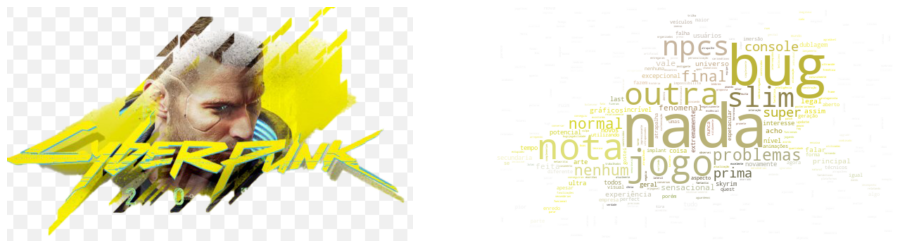

In [323]:
drawWordCloud(adjs_pt_positive,"wordcloud_cyberpunk2077_pt_positive")

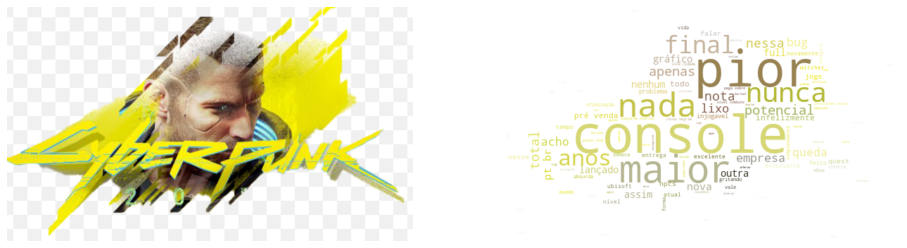

In [324]:
drawWordCloud(adjs_pt_negative,"wordcloud_cyberpunk2077_pt_negative")

Infelizmente para o português, o pos_tag do nltk, ou seja, a função responsável por identificar se uma palavra é um adjetivo não funciona muito bem para esse idioma. Há outras funções de 'taggeamento' que o nltk fornece, porém nenhuma outra teve um resultado satisfatório também.

Para tentar melhorar a nuvem, identificamos algumas palavras que estavam poluindo-a e asInfelizmente para o português, o pos_tag do nltk, ou seja, a função responsável por identificar se uma palavra é um adjetivo não funciona muito bem para esse idioma. Há outras funções de 'taggeamento' que o nltk fornece, porém nenhuma outra teve um resultado satisfatório também. tiramos manualmente

In [40]:
trash_words=['final','nunca','console','anos','nada','jogo','outra','slim','nota','prima','npcs','nenhum','vale','total']
portuguese_positive_wc=[]

for word in adjs_pt_positive:
    if word not in trash_words:
        portuguese_positive_wc.append(word)
        
portuguese_negative_wc=[]

for word in adjs_pt_negative:
    if word not in trash_words:
        portuguese_negative_wc.append(word)

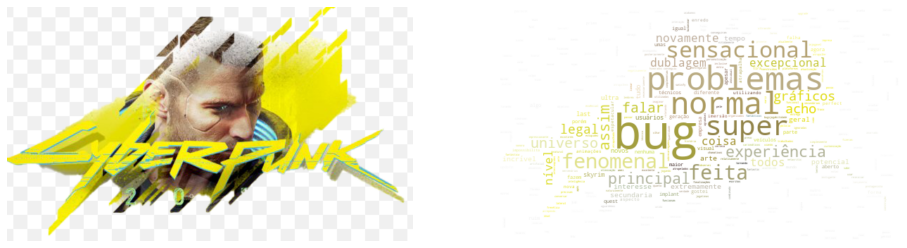

In [332]:
drawWordCloud(portuguese_positive_wc,"wordcloud_cyberpunk2077_pt_positive")

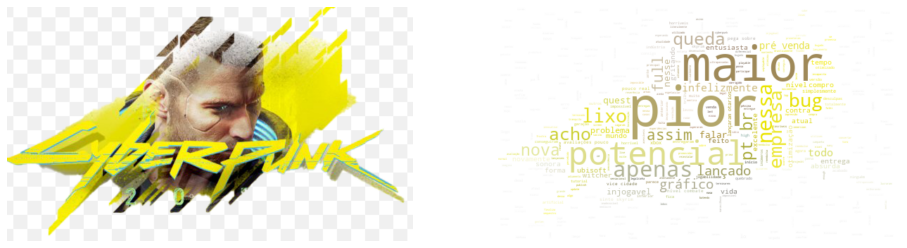

In [333]:
drawWordCloud(portuguese_negative_wc,"wordcloud_cyberpunk2077_pt_negative")

### Modelagem de tópicos

Agora vamos entrar na parte de modelagem do nosso projeto. Modelar tópicos baseia-se em identificar um conjunto de palavras pela frequência de aparição e junta-las em um conjunto. Há vários algoritmos para isso, mas usamos o LDA (Latent Dirichlet Allocation) aqui. Vamos entender como ele funciona baseado em um artigo muito legal do TowardsDataScience (https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

#### Latent Dirichlet Allocation
LDA é um algoritmo de aprendizagem não-supervisionado, onde nós não damos nenhum label para o algoritmo, que vê um documento como um conjunto de palavras. O Algoritmo funciona determinando um número de tópicos, e para cada tópico determinar um conjunto de palavras. Mas, como o algortimo acha esses tópicos? Bom, o LDA executa uma engenharia reversa onde para cada documento m ele faz o seguinte processo:

- Assumir que há k tópicos ao longo de todos os documentos;
- Distribuir esses k tópicos ao longo dos documentos m (a distribuição é conhecida como α e pode ser simétrica ou assimétrica) atribuindo cada palavra w nos k tópicos;
- Para cada palavra w, assumir que w está no tópico errado mas cada outra palavra neste e em todos os outros tópicos estão corretos;
- Probabilisticamente, atribuir cada palavra w nos tópicos baseados em dois pilares:
    - quantos tópicos existem no documento m;
    - quantas vezes cada w foi atribuída a um tópicos em particular entre todos os documentos (essa distribuição é chamada de β);
- Repetir esse processo até terminar!

α é uma matriz onde cada linha é um documento e cada coluna representa um tópico. Um valor na linha i e coluna j representa a probabilidade de o documento i conter o tópico j. Uma distribuição simétrica significaria que cada tópico é distribuído uniformemente por todo o documento, enquanto uma distribuição assimétrica favorece certos tópicos em detrimento de outros. Isso afeta o ponto de partida do modelo e pode ser usado quando você tem uma ideia aproximada de como os tópicos são distribuídos para melhorar os resultados.

β é uma matriz onde cada linha representa um tópico e cada coluna representa uma palavra. Um valor na linha i e na coluna j representa a probabilidade de esse tópico i conter a palavra j. Normalmente, cada palavra é distribuída uniformemente ao longo do tópico, de forma que nenhum tópico seja inclinado para certas palavras. No entanto, isso pode ser explorado para influenciar certos tópicos a favor de certas palavras. Por exemplo, se você sabe que tem um tópico sobre videogames, pode ser útil distorcer palavras como "xbox" e "ps4" para um dos tópicos a fim de levar o modelo a encontrar aquele tópico específico.


Perfeito! Agora entendemos basicamente como funciona o nosso algoritmo, e já podemos preparar os nosso dados para usa-lo. Nós teremos que voltar um pouco ao nosso dataframe original e corta-lo novamente. Mas por que?

Para as nuvem de palavras, nós criamos um lista com todas as nossas palavras. Para o LDA nós temos que passar várias listas. Se passarmos apenas uma lista enorme com todos os nossos tokens ele vai enteder como um único documento e o algoritmo precisa de um array de documento, que no nosso caso é cada review, para poder funcionar.


Então iremos criar quatro funções e cortar o nosso dataframe:

In [41]:
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer('english')

def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize(token))
    return result

def full_preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [42]:
reviews_en = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'en')]

Para nuvem de palavras o nosso tratamento foi tirar as stopwords e fazer lemmatize. Porém, há outra técnica que podemos usar, o stemming. Essa técnica é responsável por reduzir as palavras à sua base, por exemplo: A palavra 'tesoura' pode ser escrita de muitas formas (tesoura, tesourinha, tesourão), porém, por mais variantes que haja, há sempre uma base, que nesse caso é 'tesou', e é isso que o stemming faz, encontrar e nos retornar essa base.

Então, eu quis comparar a modelagem de tópicos aplicando e não aplicando o stemming, por isso temos uma função que chama a técnica e outra não e outras duas que a aplicam ou não.

Agora vamos rodar o modelo! Para isso, vamo aplicar nossas funções (por enquanto sem o stemming):

Então o nosso processo fica:
- Mapear a coluna review do nosso dataframe já cortado com a nossa função. Dessa forma cada linha será uma lista, ou pro modelo, um documento;
- Criar um dicionário que nos mostra todas as palavras únicas nos nossos documentos;
- Para cada documento, verificamos quantas vezes cada palavra aparece;
- Definimos um número de tópicos, no nosso caso aqui, 10.

e por fim, rodamos o modelo

Ao final temos o resultado:

In [43]:
lda_en = reviews_en['review'].map(preprocess)

# Cria um dicionário contendo o número de vezes que cada palavra aparece
dictionary = corpora.Dictionary(lda_en)
print(dictionary)

#Pra cada documento, nós criamos um dicionário que conta quantas palavras e quantas vezes essas palavras aparecem
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_en]
print(bow_corpus[:1])

# number of topics
num_topics = 10
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

Dictionary(20193 unique tokens: ['actually', 'assassin', 'awful', 'best', 'come']...)
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 6), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]]
[(0,
  '0.061*"game" + 0.021*"play" + 0.013*"like" + 0.011*"bug" + 0.010*"story" + '
  '0.010*"great" + 0.008*"really" + 0.008*"look" + 0.008*"character" + '
  '0.008*"even"'),
 (1,
  '0.037*"game" + 0.012*"story" + 0.011*"bug" + 0.008*"really" + 0.008*"like" '
  '+ 0.008*"city" + 0.007*"play" + 0.007*"time" + 0.006*"make" + 0.006*"even"'),
 (2,
  '0.040*"game" + 0.013*"bug" + 0.012*"make" + 0.011*"story" + 0.010*"play" + '
  '0.009*"even" + 0.009*"like" + 0.008*"best" + 0.007*"unplayable" + '
  '0.007*"time"'),
 (3,
  '0.074*"game" + 0.016*"bug" + 0.013*"like" + 0.009*"even" + 0.008*"story" + '
  '

Aqui temos os nosso 10 tópicos, onde cada tópico é um conjunto de palavras e cada palavra tem um peso, assim é possível observar como cada palavras 'pesa' para a construção de cada tópico.

Mas podemos melhorar um pouco a nossa visualização. Nós podemos analisar os nossos tópicos sob duas perspectivas:
- Interpretando individualmente cada tópico: Aqui, olhamos para as palavras mais frequentes em cada tópico para entender as mais relevantes para a construção do mesmo;
- Interpretando a distancia de tópicos do outro na área de plot. Assim podemos observar como um tópico está relacionado com outro ou até mesmo se um está contido em outro.

In [69]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('C:\\Users\\raphael.coelho\\PythonP\\NLP'+str(num_topics)+'en_just_lemmatize')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'C:\\Users\\raphael.coelho\\PythonP\\NLP'+ str(num_topics)+'en_just_lemmatize' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.057293 -0.010521       1        1  20.002122
3      0.064672  0.001603       2        1  19.618037
4      0.043974  0.027277       3        1  19.364003
1      0.034183  0.011787       4        1  11.874672
7      0.025261 -0.021042       5        1  10.129793
8      0.009561  0.058142       6        1   8.127657
2      0.002597 -0.034027       7        1   4.963937
5     -0.026104 -0.064477       8        1   3.165171
6     -0.095213  0.043341       9        1   1.650865
9     -0.116225 -0.012083      10        1   1.103743, topic_info=       Term        Freq       Total Category  logprob  loglift
0       bug  345.000000  345.000000  Default  30.0000  30.0000
48     muit   86.000000   86.000000  Default  29.0000  29.0000
40      gam  153.000000  153.000000  Default  28.0000  28.0000
3       jog  888.000000  888.000000  Default  27.0000  27.0000
127  melhor   80.000000   80.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
44    maior    0.463713   39.109292  Topic10  -5.7486   0.0716
286    form    0.454818   16.780691  Topic10  -5.7679   0.8984
50      nov    0.458089   26.973085  Topic10  -5.7608   0.4309
754  geraçã    0.459030   33.258333  Topic10  -5.7587   0.2235
187  nenhum    0.456446   25.618050  Topic10  -5.7644   0.4789

[753 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
989       1  0.163020  abaix
989       2  0.489060  abaix
989       6  0.326040  abaix
349       3  0.205333  abrir
349       4  0.205333  abrir
...     ...       ...    ...
528       3  0.098797   ótim
528       4  0.164661   ótim
528       5  0.131729   ótim
528       7  0.032932   ótim
528       8  0.065865   ótim

[1584 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 2, 8, 9, 3, 6, 7, 10])

In [48]:
lda_en_full = reviews_en['review'].map(full_preprocess)

# Cria um dicionário contendo o número de vezes que cada palavra aparece
dictionary = corpora.Dictionary(lda_en_full)
print(dictionary)

#Pra cada documento, nós criamos um dicionário que conta quantas palavras e quantas vezes essas palavras aparecem
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_en_full]
print(bow_corpus[:1])

# number of topics
num_topics = 10
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

Dictionary(16560 unique tokens: ['actual', 'assassin', 'aw', 'best', 'come']...)
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 6), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]]
[(0,
  '0.055*"game" + 0.013*"like" + 0.010*"realli" + 0.009*"world" + 0.009*"good" '
  '+ 0.008*"play" + 0.008*"stori" + 0.008*"time" + 0.008*"make" + 0.008*"bug"'),
 (1,
  '0.023*"game" + 0.018*"like" + 0.012*"bug" + 0.010*"quest" + 0.009*"stori" + '
  '0.008*"look" + 0.008*"play" + 0.008*"world" + 0.008*"make" + '
  '0.007*"charact"'),
 (2,
  '0.045*"game" + 0.011*"bug" + 0.010*"world" + 0.009*"play" + 0.009*"cdpr" + '
  '0.008*"cyberpunk" + 0.008*"like" + 0.007*"stori" + 0.007*"great" + '
  '0.007*"releas"'),
 (3,
  '0.051*"game" + 0.023*"play" + 0.014*"like" + 0.011*"great" + 0.010*"make" + '
  '0.0

In [62]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('C:\\Users\\raphael.coelho\\PythonP\\NLP'+str(num_topics)+'en_lemmatize_and_stemming')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'C:\\Users\\raphael.coelho\\PythonP\\NLP'+ str(num_topics)+'en_lemmatize_and_stemming'+'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.016426 -0.029531       1        1  18.325131
3      0.057034 -0.021378       2        1  17.366195
9      0.039354  0.071445       3        1  14.455562
5      0.018909 -0.049251       4        1  14.207448
0      0.002803 -0.039104       5        1  10.267269
7      0.035393  0.035073       6        1   8.365393
1      0.020868  0.011607       7        1   7.885452
4     -0.057240  0.042702       8        1   3.660525
2     -0.031534 -0.018523       9        1   3.204544
6     -0.102013 -0.003040      10        1   2.262481, topic_info=          Term        Freq       Total Category  logprob  loglift
4         jogo  661.000000  661.000000  Default  30.0000  30.0000
103    console   68.000000   68.000000  Default  29.0000  29.0000
2790      scam    8.000000    8.000000  Default  28.0000  28.0000
47       jogar   70.000000   70.000000  Default  27.0000  27.0000
285       xbox   38.000000   38.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
31      coisas    0.745567   17.473303  Topic10  -5.9914   0.6344
569      patch    0.723134   20.658689  Topic10  -6.0220   0.4364
45    história    0.842005  105.124405  Topic10  -5.8698  -1.0384
24        algo    0.687332   26.365097  Topic10  -6.0728   0.1417
147     demais    0.685214   24.465977  Topic10  -6.0758   0.2134

[766 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1269      7  0.686112  abraços
286       4  0.698146  absurdo
914       3  0.625885  acabado
914       7  0.208628  acabado
2784      2  0.768147   acabam
...     ...       ...      ...
285       7  0.156014     xbox
285       8  0.104009     xbox
285       9  0.026002     xbox
285      10  0.052005     xbox
1865      8  0.773975    zorra

[1611 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 10, 6, 1, 8, 2, 5, 3, 7])

In [50]:
stop_words = set(stopwords.words('spanish')) 
stemmer = SnowballStemmer('spanish')

def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize(token))
    return result

def full_preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [51]:
reviews_es = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'es')]

In [52]:
lda_es = reviews_es['review'].map(preprocess)

# Cria um dicionário contendo o número de vezes que cada palavra aparece
dictionary = corpora.Dictionary(lda_es)
print(dictionary)

#Pra cada documento, nós criamos um dicionário que conta quantas palavras e quantas vezes essas palavras aparecem
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_es]
print(bow_corpus[:1])

# number of topics
num_topics = 10
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

Dictionary(5028 unique tokens: ['bug', 'creer', 'demaciados', 'esperarlo', 'injugable']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]
[(0,
  '0.047*"juego" + 0.013*"bug" + 0.009*"historia" + 0.006*"gran" + '
  '0.006*"mejor" + 0.005*"juegos" + 0.005*"hacer" + 0.005*"jugar" + '
  '0.004*"sido" + 0.004*"buena"'),
 (1,
  '0.027*"juego" + 0.007*"historia" + 0.006*"estafa" + 0.006*"bug" + '
  '0.006*"consolas" + 0.005*"xbox" + 0.004*"gran" + 0.004*"mejor" + '
  '0.004*"pena" + 0.003*"producto"'),
 (2,
  '0.049*"juego" + 0.014*"bug" + 0.013*"historia" + 0.009*"bien" + '
  '0.007*"misiones" + 0.006*"mejor" + 0.006*"solo" + 0.005*"años" + '
  '0.005*"consolas" + 0.005*"horas"'),
 (3,
  '0.049*"juego" + 0.015*"bug" + 0.010*"historia" + 0.008*"mejor" + '
  '0.006*"consolas" + 0.006*"juegos" + 0.004*"mundo" + 0.004*"bien" + '
  '0.004*"injugable" + 0.004*"roto"'),
 (4,
  '0.043*"juego" + 0.013*"bug" + 0.009*"historia" + 0.006*"gran" + '
  '0.005*"

In [63]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('C:\\Users\\raphael.coelho\\PythonP\\NLP'+str(num_topics)+'es_just_lemmatize')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'C:\\Users\\raphael.coelho\\PythonP\\NLP'+ str(num_topics)+'es_just_lemmatize' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.016426 -0.029531       1        1  18.294067
3      0.057034 -0.021378       2        1  17.383966
9      0.039354  0.071445       3        1  14.471913
5      0.018909 -0.049251       4        1  14.205762
0      0.002803 -0.039104       5        1  10.299513
7      0.035393  0.035073       6        1   8.281888
1      0.020868  0.011607       7        1   7.910595
4     -0.057240  0.042702       8        1   3.675946
2     -0.031534 -0.018523       9        1   3.224906
6     -0.102013 -0.003040      10        1   2.251445, topic_info=          Term        Freq       Total Category  logprob  loglift
4         jogo  661.000000  661.000000  Default  30.0000  30.0000
103    console   68.000000   68.000000  Default  29.0000  29.0000
2790      scam    8.000000    8.000000  Default  28.0000  28.0000
47       jogar   70.000000   70.000000  Default  27.0000  27.0000
285       xbox   38.000000   38.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
31      coisas    0.741930   17.486538  Topic10  -5.9914   0.6337
569      patch    0.719607   20.666561  Topic10  -6.0220   0.4360
45    história    0.837898  105.146526  Topic10  -5.8698  -1.0386
24        algo    0.683980   26.345113  Topic10  -6.0728   0.1425
147     demais    0.681872   24.461514  Topic10  -6.0758   0.2136

[766 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1269      7  0.684946  abraços
286       4  0.698691  absurdo
914       3  0.625070  acabado
914       7  0.208357  acabado
2784      2  0.767536   acabam
...     ...       ...      ...
285       7  0.155977     xbox
285       8  0.103984     xbox
285       9  0.025996     xbox
285      10  0.051992     xbox
1865      8  0.772462    zorra

[1610 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 10, 6, 1, 8, 2, 5, 3, 7])

In [54]:
lda_es_full = reviews_es['review'].map(full_preprocess)

# Cria um dicionário contendo o número de vezes que cada palavra aparece
dictionary = corpora.Dictionary(lda_es_full)
print(dictionary)

#Pra cada documento, nós criamos um dicionário que conta quantas palavras e quantas vezes essas palavras aparecem
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_es_full]
print(bow_corpus[:1])

# number of topics
num_topics = 10
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

Dictionary(2885 unique tokens: ['bug', 'cre', 'demaci', 'esper', 'injug']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]
[(0,
  '0.056*"jueg" + 0.015*"pued" + 0.013*"hac" + 0.012*"bug" + 0.012*"buen" + '
  '0.011*"jug" + 0.011*"histori" + 0.009*"mejor" + 0.009*"esper" + '
  '0.007*"sol"'),
 (1,
  '0.033*"jueg" + 0.017*"pued" + 0.014*"bug" + 0.012*"mejor" + 0.011*"jug" + '
  '0.008*"histori" + 0.007*"hac" + 0.007*"buen" + 0.007*"gener" + '
  '0.007*"consol"'),
 (2,
  '0.049*"jueg" + 0.013*"mejor" + 0.011*"bug" + 0.009*"pued" + 0.008*"grafic" '
  '+ 0.008*"consol" + 0.008*"hor" + 0.008*"jug" + 0.007*"optimiz" + '
  '0.007*"bien"'),
 (3,
  '0.051*"jueg" + 0.015*"bug" + 0.014*"jug" + 0.011*"hac" + 0.009*"histori" + '
  '0.007*"mejor" + 0.007*"decepcion" + 0.007*"años" + 0.006*"error" + '
  '0.006*"consol"'),
 (4,
  '0.043*"jueg" + 0.013*"bug" + 0.012*"hac" + 0.009*"jug" + 0.009*"histori" + '
  '0.007*"part" + 0.006*"increibl" + 0.006*"buen" 

In [64]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('C:\\Users\\raphael.coelho\\PythonP\\NLP'+str(num_topics)+'es_lemmatize_and_stemming')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'C:\\Users\\raphael.coelho\\PythonP\\NLP'+ str(num_topics)+'es_lemmatize_and_stemming' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.016426 -0.029531       1        1  18.311066
3      0.057034 -0.021378       2        1  17.365837
9      0.039354  0.071445       3        1  14.499124
5      0.018909 -0.049251       4        1  14.207073
0      0.002803 -0.039104       5        1  10.272162
7      0.035393  0.035073       6        1   8.286038
1      0.020868  0.011607       7        1   7.910639
4     -0.057240  0.042702       8        1   3.660828
2     -0.031534 -0.018523       9        1   3.225188
6     -0.102013 -0.003040      10        1   2.262045, topic_info=          Term        Freq       Total Category  logprob  loglift
4         jogo  661.000000  661.000000  Default  30.0000  30.0000
103    console   68.000000   68.000000  Default  29.0000  29.0000
2790      scam    8.000000    8.000000  Default  28.0000  28.0000
47       jogar   70.000000   70.000000  Default  27.0000  27.0000
285       xbox   38.000000   38.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
31      coisas    0.745423   17.485171  Topic10  -5.9914   0.6337
569      patch    0.722995   20.664470  Topic10  -6.0220   0.4361
45    história    0.841843  105.161470  Topic10  -5.8698  -1.0388
24        algo    0.687200   26.352904  Topic10  -6.0728   0.1422
147     demais    0.685082   24.451439  Topic10  -6.0758   0.2140

[766 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1269      7  0.684966  abraços
286       4  0.698152  absurdo
914       3  0.624259  acabado
914       7  0.208086  acabado
2784      2  0.768127   acabam
...     ...       ...      ...
285       7  0.155934     xbox
285       8  0.103956     xbox
285       9  0.025989     xbox
285      10  0.051978     xbox
1865      8  0.773883    zorra

[1610 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 10, 6, 1, 8, 2, 5, 3, 7])

In [56]:
stop_words = set(stopwords.words('portuguese')) 
stemmer = SnowballStemmer('portuguese')

def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize(token))
    return result

def full_preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [57]:
reviews_pt = reviews_cyberpunk.loc[(reviews_cyberpunk['language'] == 'pt')]

In [58]:
lda_pt = reviews_pt['review'].map(preprocess)

# Cria um dicionário contendo o número de vezes que cada palavra aparece
dictionary = corpora.Dictionary(lda_pt)
print(dictionary)

#Pra cada documento, nós criamos um dicionário que conta quantas palavras e quantas vezes essas palavras aparecem
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_pt]
print(bow_corpus[:1])

# number of topics
num_topics = 10
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

Dictionary(3440 unique tokens: ['bug', 'cheio', 'extremamente', 'jogando', 'jogo']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]
[(0,
  '0.042*"jogo" + 0.021*"bug" + 0.013*"game" + 0.008*"problemas" + '
  '0.007*"nada" + 0.007*"história" + 0.005*"cyberpunk" + 0.005*"gráficos" + '
  '0.005*"imersão" + 0.005*"apenas"'),
 (1,
  '0.043*"jogo" + 0.022*"bug" + 0.010*"game" + 0.009*"jogar" + '
  '0.007*"história" + 0.007*"crash" + 0.006*"xbox" + 0.006*"problemas" + '
  '0.005*"bugado" + 0.005*"personagens"'),
 (2,
  '0.033*"jogo" + 0.012*"game" + 0.008*"todo" + 0.007*"bug" + 0.007*"história" '
  '+ 0.006*"horrível" + 0.006*"lixo" + 0.005*"empresa" + 0.005*"nunca" + '
  '0.005*"injogavel"'),
 (3,
  '0.061*"jogo" + 0.019*"bug" + 0.013*"game" + 0.008*"empresa" + 0.007*"todo" '
  '+ 0.006*"história" + 0.006*"console" + 0.006*"bugado" + 0.005*"anos" + '
  '0.005*"problemas"'),
 (4,
  '0.022*"jogo" + 0.010*"console" + 0.008*"xbox" + 0.007*"história"

In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('C:\\Users\\raphael.coelho\\PythonP\\NLP'+str(num_topics)+'pt_just_lemmatize')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'C:\\Users\\raphael.coelho\\PythonP\\NLP'+ str(num_topics)+'pt_just_lemmatize' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.016426 -0.029531       1        1  18.300603
3      0.057034 -0.021378       2        1  17.383122
9      0.039354  0.071445       3        1  14.441415
5      0.018909 -0.049251       4        1  14.199521
0      0.002803 -0.039104       5        1  10.295579
7      0.035393  0.035073       6        1   8.341448
1      0.020868  0.011607       7        1   7.886239
4     -0.057240  0.042702       8        1   3.676851
2     -0.031534 -0.018523       9        1   3.223755
6     -0.102013 -0.003040      10        1   2.251467, topic_info=          Term        Freq       Total Category  logprob  loglift
4         jogo  661.000000  661.000000  Default  30.0000  30.0000
103    console   68.000000   68.000000  Default  29.0000  29.0000
2790      scam    8.000000    8.000000  Default  28.0000  28.0000
47       jogar   70.000000   70.000000  Default  27.0000  27.0000
285       xbox   38.000000   38.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
31      coisas    0.741937   17.475440  Topic10  -5.9914   0.6343
569      patch    0.719614   20.661826  Topic10  -6.0220   0.4363
45    história    0.837906  105.116608  Topic10  -5.8698  -1.0383
24        algo    0.683987   26.353757  Topic10  -6.0728   0.1422
147     demais    0.681878   24.472684  Topic10  -6.0758   0.2131

[766 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1269      7  0.685984  abraços
286       4  0.698860  absurdo
914       3  0.626276  acabado
914       7  0.208759  acabado
2784      2  0.767550   acabam
...     ...       ...      ...
285       7  0.156035     xbox
285       8  0.104023     xbox
285       9  0.026006     xbox
285      10  0.052012     xbox
1865      8  0.772353    zorra

[1610 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 10, 6, 1, 8, 2, 5, 3, 7])

In [66]:
lda_pt_full = reviews_pt['review'].map(full_preprocess)

# Cria um dicionário contendo o número de vezes que cada palavra aparece
dictionary = corpora.Dictionary(lda_pt_full)
print(dictionary)

#Pra cada documento, nós criamos um dicionário que conta quantas palavras e quantas vezes essas palavras aparecem
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_pt_full]
print(bow_corpus[:1])

# number of topics
num_topics = 10
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

Dictionary(2226 unique tokens: ['bug', 'chei', 'extrem', 'jog', 'mecân']...)
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]
[(0,
  '0.079*"jog" + 0.032*"bug" + 0.017*"gam" + 0.009*"melhor" + 0.008*"tod" + '
  '0.008*"muit" + 0.008*"otimiz" + 0.008*"compr" + 0.007*"histór" + '
  '0.007*"dev"'),
 (1,
  '0.063*"jog" + 0.031*"bug" + 0.012*"histór" + 0.012*"gam" + 0.010*"muit" + '
  '0.008*"consol" + 0.008*"horrível" + 0.006*"compr" + 0.006*"temp" + '
  '0.006*"tod"'),
 (2,
  '0.043*"jog" + 0.013*"bug" + 0.013*"histór" + 0.010*"anos" + 0.010*"fic" + '
  '0.009*"gráfic" + 0.009*"ness" + 0.008*"nad" + 0.008*"lanc" + '
  '0.008*"consol"'),
 (3,
  '0.098*"jog" + 0.032*"bug" + 0.010*"tod" + 0.009*"gráfic" + 0.008*"problem" '
  '+ 0.008*"melhor" + 0.007*"histór" + 0.007*"esper" + 0.007*"xbox" + '
  '0.007*"nad"'),
 (4,
  '0.063*"jog" + 0.019*"bug" + 0.012*"tod" + 0.011*"histór" + 0.010*"gam" + '
  '0.010*"compr" + 0.008*"problem" + 0.007*"muit" + 0.007*"apen" +

In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('C:\\Users\\raphael.coelho\\PythonP\\NLP'+str(num_topics)+'pt_lemmatize_and_stemming')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'C:\\Users\\raphael.coelho\\PythonP\\NLP'+ str(num_topics)+'pt_lemmatize_and_stemming' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.057293 -0.010521       1        1  19.920674
3      0.064672  0.001603       2        1  19.627105
4      0.043974  0.027277       3        1  19.370351
1      0.034183  0.011787       4        1  11.868697
7      0.025261 -0.021042       5        1  10.147233
8      0.009561  0.058142       6        1   8.109243
2      0.002597 -0.034027       7        1   5.032705
5     -0.026104 -0.064477       8        1   3.165406
6     -0.095213  0.043341       9        1   1.654586
9     -0.116225 -0.012083      10        1   1.103998, topic_info=       Term        Freq       Total Category  logprob  loglift
0       bug  345.000000  345.000000  Default  30.0000  30.0000
48     muit   86.000000   86.000000  Default  29.0000  29.0000
40      gam  153.000000  153.000000  Default  28.0000  28.0000
3       jog  888.000000  888.000000  Default  27.0000  27.0000
127  melhor   80.000000   80.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
44    maior    0.463821   39.128618  Topic10  -5.7486   0.0711
286    form    0.454924   16.769337  Topic10  -5.7679   0.8991
50      nov    0.458196   26.952571  Topic10  -5.7608   0.4317
754  geraçã    0.459136   33.273728  Topic10  -5.7587   0.2231
187  nenhum    0.456551   25.627651  Topic10  -5.7644   0.4785

[754 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
989       1  0.163108  abaix
989       2  0.489325  abaix
989       6  0.326217  abaix
349       3  0.204503  abrir
349       4  0.204503  abrir
...     ...       ...    ...
528       3  0.098811   ótim
528       4  0.164685   ótim
528       5  0.131748   ótim
528       7  0.032937   ótim
528       8  0.065874   ótim

[1594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 2, 8, 9, 3, 6, 7, 10])